In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import configparser
import os
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.analysis_utils as analysis
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import scipy
from IPython.display import Image, display_png

%matplotlib inline

28-ID - VKB Pitch Motor Resolution: 2e-05 deg
Qt5Agg: unable to import specified backend (or its dependency); no plots


**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.
Traceback (most recent call last):
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot.py", line 57, in uti_plot_init
    _backend = uti_plot_matplotlib.Backend(backend, fname_format)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot_matplotlib.py", line 27, in __init__
    backend = self._init_ipython(backend)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot_matplotlib.py", line 724, in _init_ipython
    get_ipython().magic('matplotlib ' + b)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.

In [4]:
exp_type = 'peak_fwhm_nlpi'

In [5]:
#base_dir = Path(aps.__file__).parents[1]
#autoalign_dir = base_dir / f'work_directory/28-ID/AI/autoalignment/'
autoalign_dir = Path("/Users/skandel/Library/CloudStorage/Box-Box/Beamtime_28ID_Nov2022/AI/autofocusing/")
data_base_dir = autoalign_dir / exp_type / 'all_motors_coma_denoised'
print(f'data base dir exists {data_base_dir.exists()}')


data base dir exists True


In [6]:
!ls {data_base_dir}

initial_motor_positions.json
peak_fwhm_nlpi_moo_100_2022-11-21_images
peak_fwhm_nlpi_moo_100_2022-11-21_steps
peak_fwhm_nlpi_moo_autofocusing.ini
peak_fwhm_nlpi_moo_optimization_final_101_2022-11-21_23:54.gz


### peak_fwhm_150_2022-11-21

In [7]:
!ls {data_base_dir}

initial_motor_positions.json
peak_fwhm_nlpi_moo_100_2022-11-21_images
peak_fwhm_nlpi_moo_100_2022-11-21_steps
peak_fwhm_nlpi_moo_autofocusing.ini
peak_fwhm_nlpi_moo_optimization_final_101_2022-11-21_23:54.gz


In [8]:
log_file = Path(data_base_dir / 'peak_fwhm_nlpi_moo_optimization_final_101_2022-11-21_23:54.gz')
log_file.exists()

True

In [9]:
hist_dir = Path(data_base_dir / 'peak_fwhm_nlpi_moo_100_2022-11-21_steps')
hist_dir.exists()

True

In [10]:
study = analysis.create_study_from_trials(log_file, n_objectives=3)

[I 2022-11-29 17:06:46,109] A new study created in memory with name: no-name-435963c5-b0be-42f4-87ad-ed9e53d6967e


Assuming minimization for all objectives.


In [11]:
n_steps = len(study.trials)

In [12]:
hists = analysis.load_histograms_from_files(n_steps, hist_dir, extension='gz')

Trial values: peak_distance 8.667e-02 fwhm 3.154e-02 nlpi -9.471e+00
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.35646814489455236, 'h_fwhm': 0.030564150069478657, 'h_centroid': -0.01830616042528782, 'h_peak': -0.07510977304307553, 'v_sigma': 0.35954331985530696, 'v_fwhm': 0.007803048065651019, 'v_centroid': 0.0577814132583097, 'v_peak': -0.04324189136381406, 'integral_intensity': 22.72542960338701, 'peak_intensity': 12975.027, 'gaussian_fit': {}}}


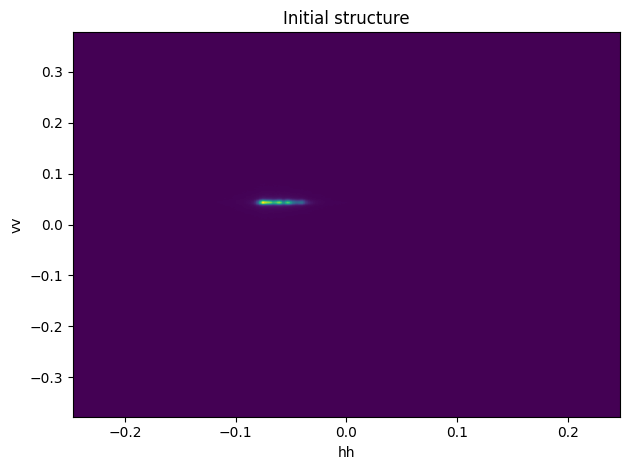

In [13]:
print(f"Trial values: peak_distance {study.trials[0].values[0]:4.3e} fwhm {study.trials[0].values[1]:4.3e} " +
     f"nlpi {study.trials[0].values[2]:4.3e}")
print("Trial dw:")
print(study.trials[0].user_attrs["dw"].__dict__)


plt.pcolormesh(hists[0].hh[700:-700], hists[0].vv[700:-700], hists[0].data_2D[700:-700,700:-700].T)
plt.xlabel('hh')
plt.ylabel('vv')
plt.title("Initial structure")
plt.tight_layout()
plt.show()

In [14]:
nash_trial, nash_idx, n_doms = analysis.select_nash_equil_trial_from_pareto_front(study)

In [15]:
print(n_doms)
print(nash_trial.number, nash_trial.values)
print(nash_trial.user_attrs["dw"].__dict__)
print("Actual fwhm (not with reference)", opt_common._get_fwhm_from_dw(nash_trial.user_attrs["dw"]))

[79, 6, 72, 21, 77, 54, 61, 76, 68]
14 [0.015034329772026447, 0.008327681846616235, -10.474681854248047]
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3513732922763021, 'h_fwhm': 0.006503010653080565, 'h_centroid': -0.0007485916794802705, 'h_peak': 0.013981472904122291, 'v_sigma': 0.3504539541830432, 'v_fwhm': 0.005202032043767346, 'v_centroid': 0.05046462514258507, 'v_peak': 0.0055271590465025494, 'integral_intensity': 20.44946383800212, 'peak_intensity': 35407.59, 'gaussian_fit': {}}}
Actual fwhm (not with reference) 0.008327681846616235


Trial number 14
Trial values: peak_distance 1.503e-02 fwhm 8.328e-03
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3513732922763021, 'h_fwhm': 0.006503010653080565, 'h_centroid': -0.0007485916794802705, 'h_peak': 0.013981472904122291, 'v_sigma': 0.3504539541830432, 'v_fwhm': 0.005202032043767346, 'v_centroid': 0.05046462514258507, 'v_peak': 0.0055271590465025494, 'integral_intensity': 20.44946383800212, 'peak_intensity': 35407.59, 'gaussian_fit': {}}}
Actual fwhm 0.008327681846616235


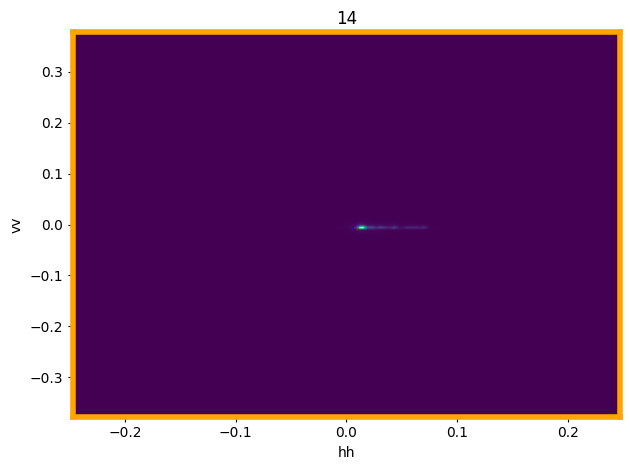

Trial number 38
Trial values: peak_distance 1.179e-01 fwhm 8.277e-03
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3545426794812699, 'h_fwhm': 0.005852709587772509, 'h_centroid': -0.027401262210300842, 'h_peak': -0.11022603056970824, 'v_sigma': 0.3531881068302499, 'v_fwhm': 0.0058522860492382645, 'v_centroid': 0.05904144445951255, 'v_peak': -0.04194138335287222, 'integral_intensity': 21.273793897142312, 'peak_intensity': 30084.662, 'gaussian_fit': {}}}
Actual fwhm 0.008276681794107652


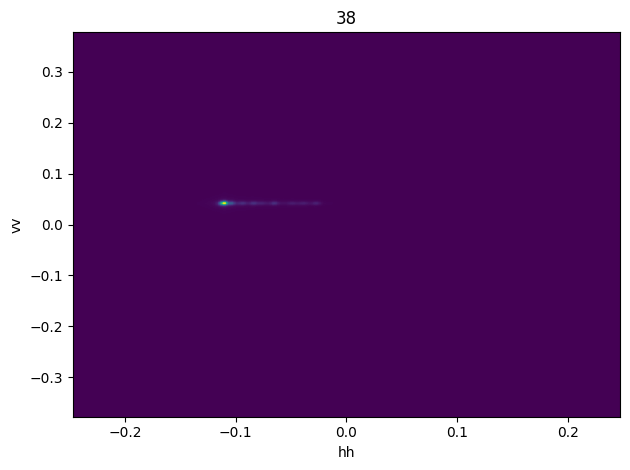

Trial number 42
Trial values: peak_distance 6.583e-03 fwhm 1.012e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3530657518686043, 'h_fwhm': 0.007153311718388622, 'h_centroid': -0.005369512060728554, 'h_peak': -0.003576655859194136, 'v_sigma': 0.35350617979916565, 'v_fwhm': 0.007152794060180101, 'v_centroid': 0.050305787451366296, 'v_peak': 0.0055271590465025494, 'integral_intensity': 21.275267144422028, 'peak_intensity': 28243.799, 'gaussian_fit': {}}}
Actual fwhm 0.010115944415020464


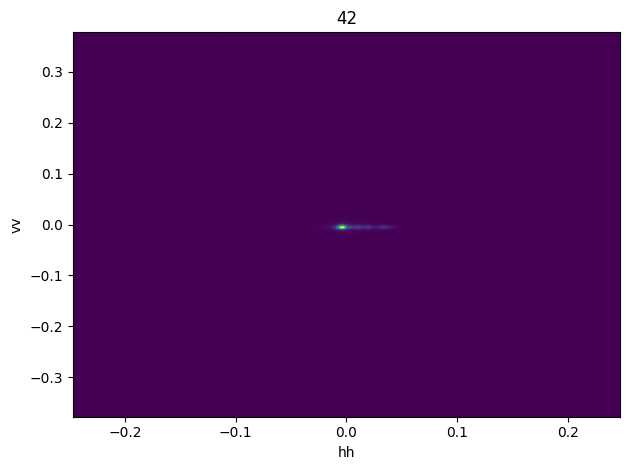

Trial number 53
Trial values: peak_distance 2.944e-03 fwhm 1.551e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.35131000064566426, 'h_fwhm': 0.008453913849004735, 'h_centroid': -0.006527275413845485, 'h_peak': -0.00032515053265395866, 'v_sigma': 0.34993661799732123, 'v_fwhm': 0.013005080109418365, 'v_centroid': 0.05070714113785564, 'v_peak': 0.0029261430246188755, 'integral_intensity': 20.38929750162238, 'peak_intensity': 16912.63, 'gaussian_fit': {}}}
Actual fwhm 0.015511310970346229


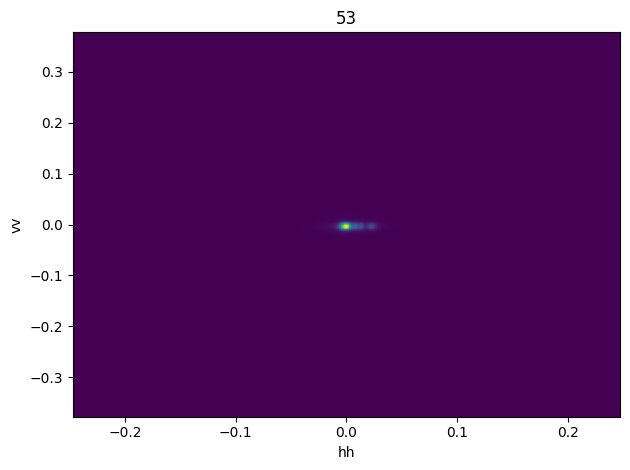

Trial number 57
Trial values: peak_distance 1.093e-02 fwhm 9.379e-03
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3531601928187154, 'h_fwhm': 0.0078036127836966784, 'h_centroid': -0.0057683705257100815, 'h_peak': -0.010079666512274196, 'v_sigma': 0.3580257122460368, 'v_fwhm': 0.005202032043767346, 'v_centroid': 0.04978724857615084, 'v_peak': 0.004226651035560713, 'integral_intensity': 22.20060175156245, 'peak_intensity': 32557.521, 'gaussian_fit': {}}}
Actual fwhm 0.009378566514252404


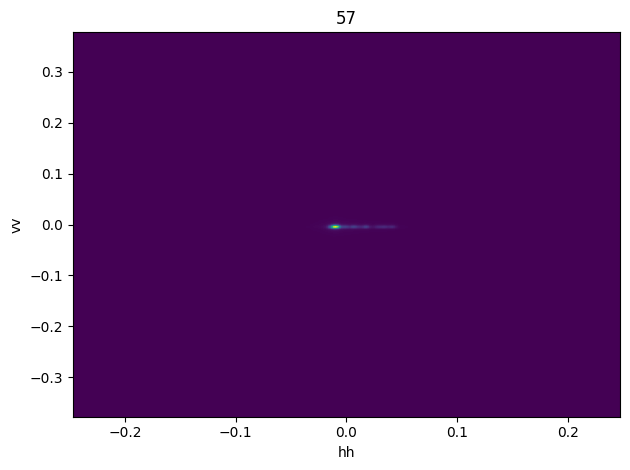

Trial number 64
Trial values: peak_distance 3.348e-03 fwhm 1.119e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3504090478316827, 'h_fwhm': 0.006503010653080565, 'h_centroid': -0.004506993001851506, 'h_peak': 0.0029263547938860714, 'v_sigma': 0.34711882908175684, 'v_fwhm': 0.009103556076592856, 'v_centroid': 0.05149856310571552, 'v_peak': 0.0016256350136771857, 'integral_intensity': 20.019136933959068, 'peak_intensity': 23124.234, 'gaussian_fit': {}}}
Actual fwhm 0.011187666458817497


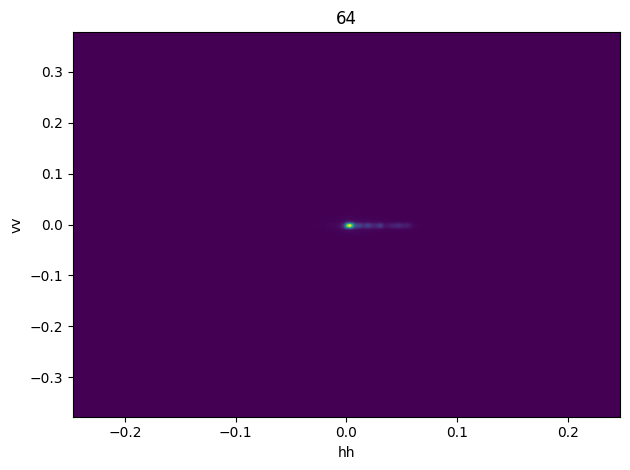

Trial number 78
Trial values: peak_distance 1.651e-02 fwhm 1.018e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3526955531847047, 'h_fwhm': 0.009104214914312792, 'h_centroid': -0.005958788727705722, 'h_peak': 0.008779064381658213, 'v_sigma': 0.3564559188955999, 'v_fwhm': 0.004551778038296428, 'v_centroid': 0.05321663940099605, 'v_peak': -0.013980461117624122, 'integral_intensity': 21.60234326351024, 'peak_intensity': 46371.02, 'gaussian_fit': {}}}
Actual fwhm 0.010178674398757097


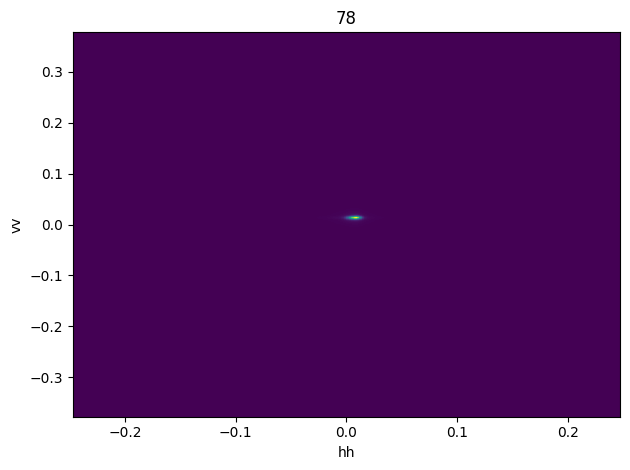

Trial number 87
Trial values: peak_distance 1.337e-02 fwhm 9.242e-03
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3491767240729317, 'h_fwhm': 0.007153311718388622, 'h_centroid': -0.005446256883863021, 'h_peak': -0.0042269569245020535, 'v_sigma': 0.3475746798056788, 'v_fwhm': 0.0058522860492382645, 'v_centroid': 0.04914342288965634, 'v_peak': 0.012679953106682285, 'integral_intensity': 19.797151890342718, 'peak_intensity': 29397.875, 'gaussian_fit': {}}}
Actual fwhm 0.00924224650950973


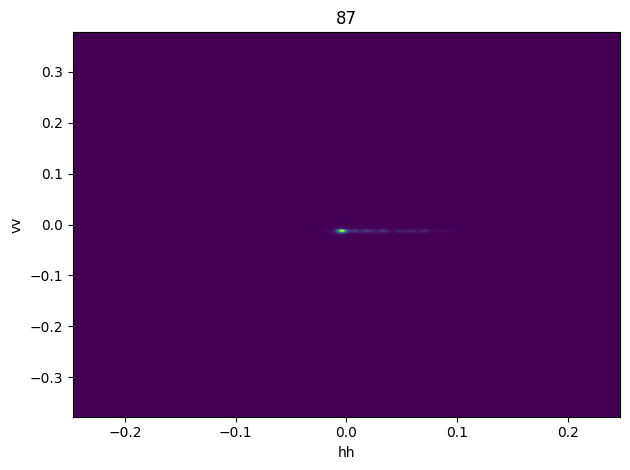

Trial number 90
Trial values: peak_distance 2.261e-02 fwhm 8.479e-03
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3542728858400293, 'h_fwhm': 0.007153311718388622, 'h_centroid': -0.0006256799153167569, 'h_peak': 0.014631773969430356, 'v_sigma': 0.3552220155429899, 'v_fwhm': 0.004551778038296428, 'v_centroid': 0.05430694834742816, 'v_peak': -0.017231731144978495, 'integral_intensity': 21.660667617929466, 'peak_intensity': 35468.555, 'gaussian_fit': {}}}
Actual fwhm 0.008478711685766515


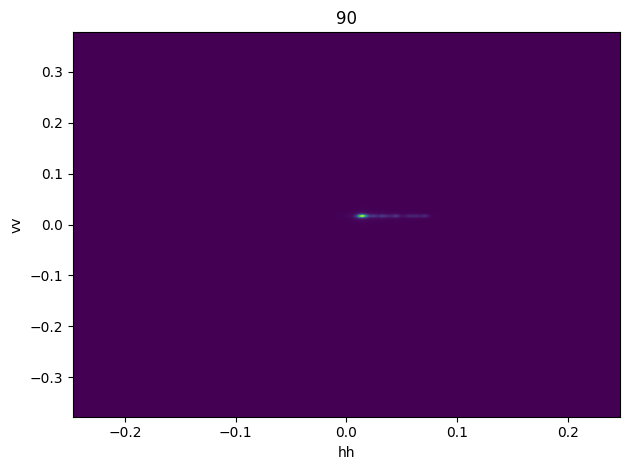

In [16]:
best_hists = []
for t in study.best_trials:
    print("Trial number", t.number)
    print(f"Trial values: peak_distance {t.values[0]:4.3e} fwhm {t.values[1]:4.3e}")
    print("Trial dw:")
    print(t.user_attrs["dw"].__dict__)
    print("Actual fwhm", opt_common._get_fwhm_from_dw(t.user_attrs["dw"]))
    hist = hists[t.number]
    plt.pcolormesh(hist.hh[700:-700], hist.vv[700:-700], hist.data_2D[700:-700,700:-700].T)
    if t.number == nash_trial.number:
        for axis in ['top','bottom','left','right']:
            plt.gca().spines[axis].set_linewidth(4)
            plt.gca().spines[axis].set_color('orange')
    plt.xlabel('hh')
    plt.ylabel('vv')
    plt.title(t.number)
    plt.tight_layout()
    plt.show()

In [17]:
study.best_trials[0].values

[0.015034329772026447, 0.008327681846616235, -10.474681854248047]

In [18]:
pareto_df = analysis.get_pareto_dataframe_from_study(study, ['peak_distance', 'fwhm', 'nlpi'])

In [19]:
pareto_df

,number,peak_distance,fwhm,nlpi,h_peak,v_peak,h_fwhm,v_fwhm,peak_intensity
14,14,0.015034,0.008328,-10.474682,0.013981,0.005527,0.006503,0.005202,35407.589844
38,38,0.117936,0.008277,-10.311770,-0.110226,-0.041941,0.005853,0.005852,30084.662109
42,42,0.006583,0.010116,-10.248630,-0.003577,0.005527,0.007153,0.007153,28243.798828
53,53,0.002944,0.015511,-9.735816,-0.000325,0.002926,0.008454,0.013005,16912.630859
57,57,0.010930,0.009379,-10.390763,-0.010080,0.004227,0.007804,0.005202,32557.521484
64,64,0.003348,0.011188,-10.048636,0.002926,0.001626,0.006503,0.009104,23124.234375
78,78,0.016508,0.010179,-10.744430,0.008779,-0.013980,0.009104,0.004552,46371.019531
87,87,0.013366,0.009242,-10.288677,-0.004227,0.012680,0.007153,0.005852,29397.875000
90,90,0.022606,0.008479,-10.476402,0.014632,-0.017232,0.007153,0.004552,35468.554688


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_46130/2375896861.py:3: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(study, target_names=["peak_distance", "delta_fwhm", "nlpi"], include_dominated_trials=False)


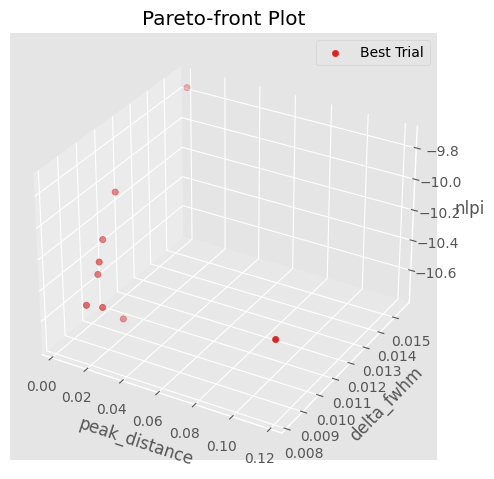

In [20]:
# Generating the pareto front for the multiobjective optimization

optuna.visualization.matplotlib.plot_pareto_front(study, target_names=["peak_distance", "delta_fwhm", "nlpi"], include_dominated_trials=False)
#plt.scatter(*nash_trial.values, color='orange', label='Nash')
plt.legend(loc='best')
plt.tight_layout()

# plt.savefig(...) to save the image
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_46130/320309324.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="peak_distance")


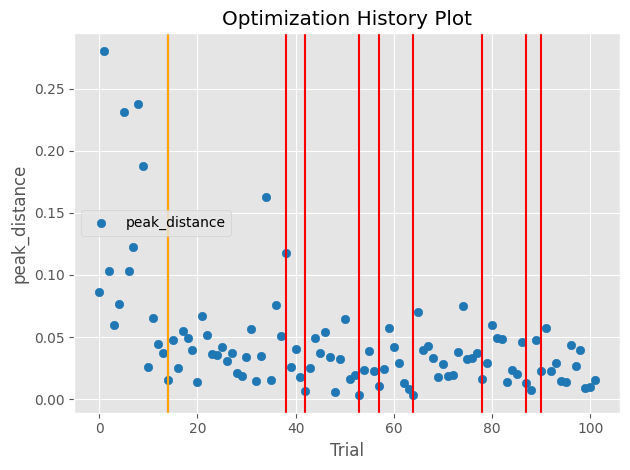

CA client library is unable to contact CA repeater after 50 tries.
Silence this message by starting a CA repeater daemon
or by calling ca_pend_event() and or ca_poll() more often.


In [21]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="peak_distance")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='orange')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_46130/759872831.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[1],


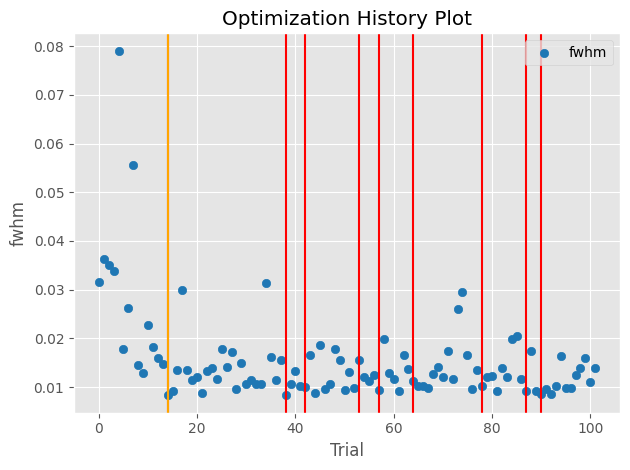

In [23]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[1], 
                                                          target_name="fwhm")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='orange')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_46130/3199083138.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[2], target_name="nlpi")


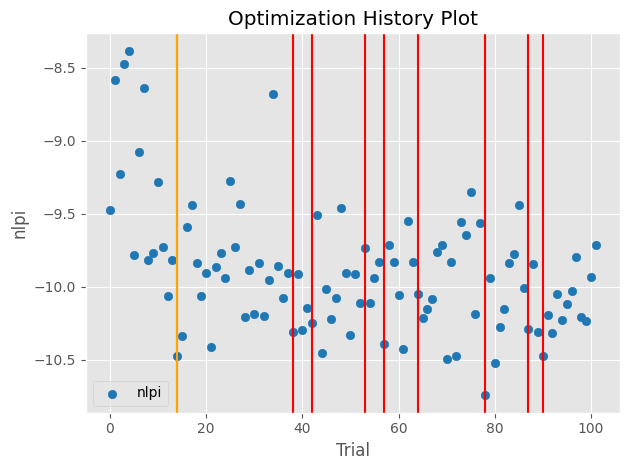

In [24]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[2], target_name="nlpi")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='orange')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

#### The remaining part is just testing how lwsi with thresholding performs in selecting the structures. This is for my own satisfaction. - SK

In [25]:
isums = []
wsums_no_thres = []
wsums_thres = []
for h in hists:
    isum1, wsum1 = analysis.calculate_weighted_sum(h, threshold=0)
    isum2, wsum2 = analysis.calculate_weighted_sum(h)
    isums.append((isum1, isum2))
    wsums_no_thres.append(wsum1)
    wsums_thres.append(wsum2)
isums = np.array(isums)
wsums_no_thres = np.array(wsums_no_thres)
wsums_thres = np.array(wsums_thres)
                      

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_46130/214102518.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums_no_thres[t.number]),


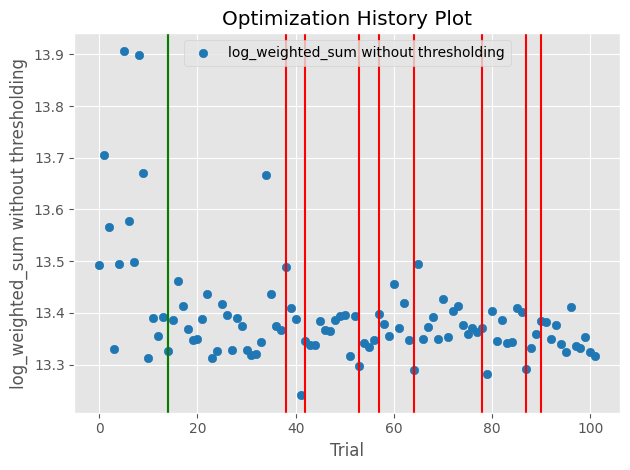

In [26]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums_no_thres[t.number]),
                                                          target_name="log_weighted_sum without thresholding")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='green')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_46130/2958963105.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums_thres[t.number]),


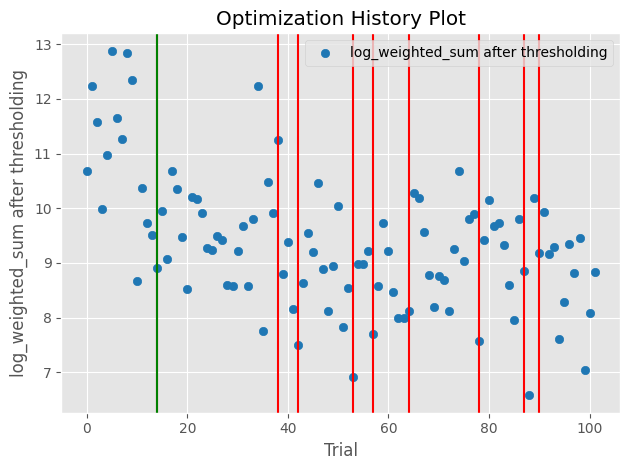

In [27]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums_thres[t.number]),
                                                          target_name="log_weighted_sum after thresholding")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='green')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [33]:
test_val_fns = [lambda t: t.values[0], lambda t: t.values[2], 
                lambda t: np.log(wsums_thres[t.number])]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials,
                                               study.directions, 
                                               values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1,1, 1], test_val_fns)
print(np.argmax(domins))

57


14 [0.015034329772026447, -10.474681854248047, 8.904947230229762]


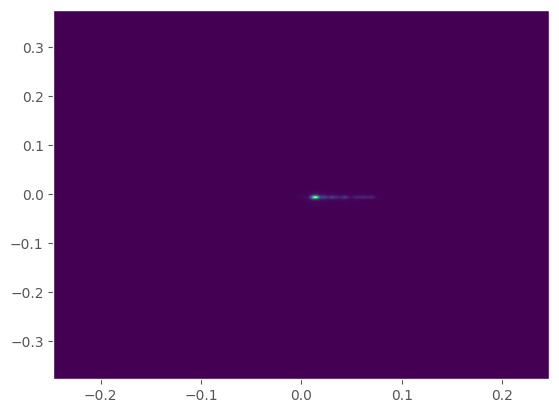

42 [0.006583460659899375, -10.248629570007324, 7.498226483031364]


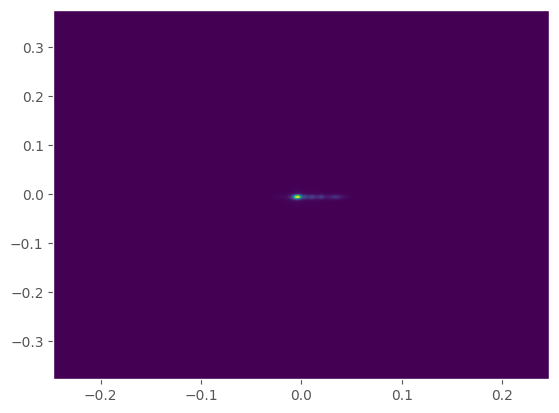

53 [0.0029441528271152728, -9.73581600189209, 6.920428437561555]


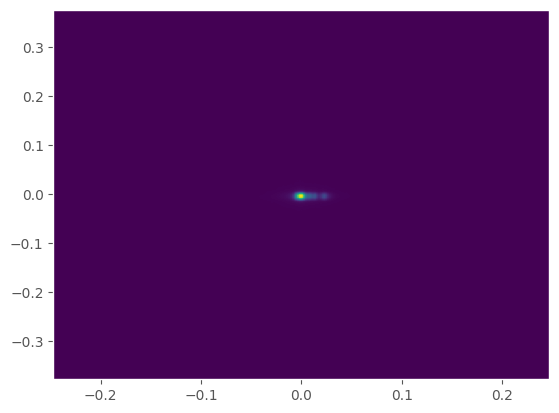

57 [0.010929970538618496, -10.390763282775879, 7.698447050415632]


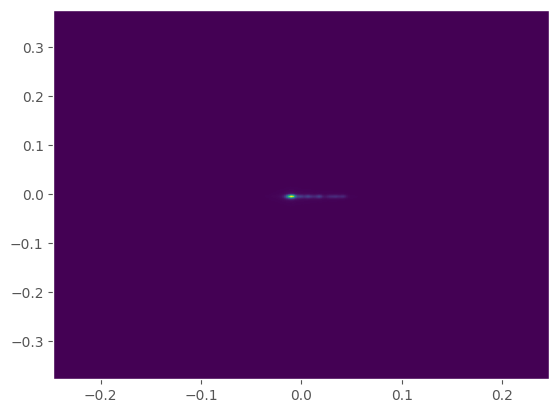

64 [0.003347572490237249, -10.048636436462402, 8.127004270545157]


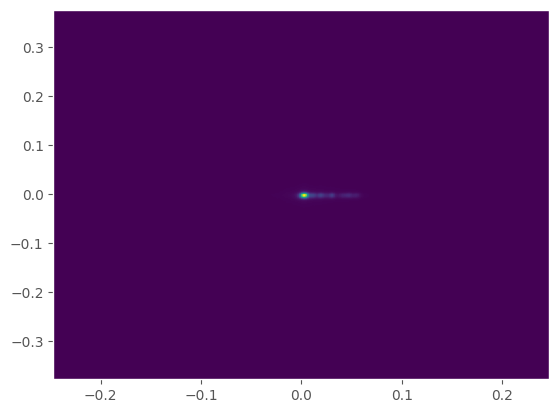

78 [0.01650833924047782, -10.744429588317871, 7.567238218935955]


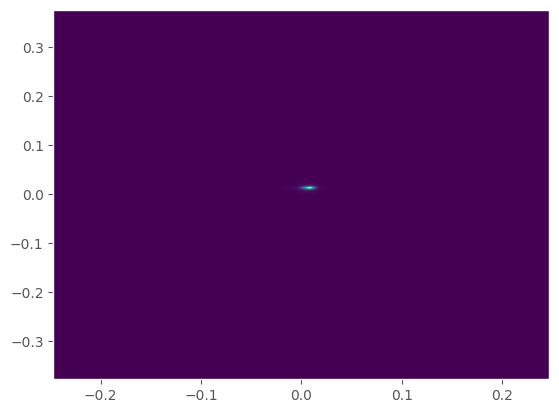

88 [0.006958207525428573, -9.841083526611328, 6.578722364984213]


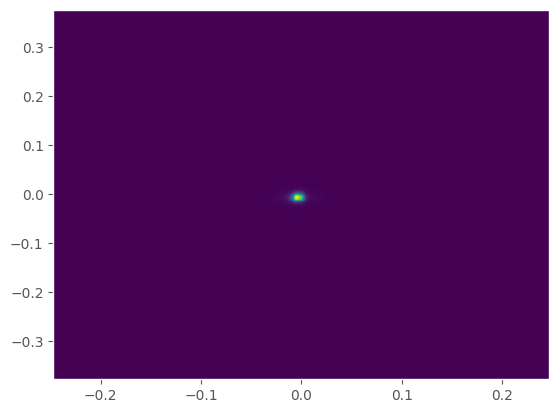

99 [0.008590225644106744, -10.231554985046387, 7.047079395405668]


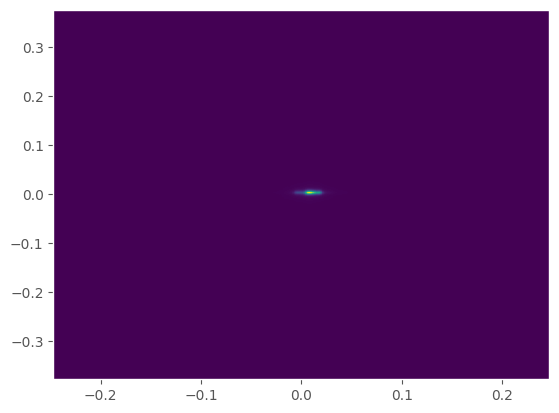

In [34]:
for t in test_pareto:
    print(t.number, test_values[t.number])
    hdata = hists[t.number]
    
    plt.pcolormesh(hdata.hh[700:-700], hdata.vv[700:-700][:,None], hdata.data_2D[700:-700,700:-700].T)
    plt.show()

In [35]:
test_val_fns = [lambda t: t.values[0], lambda t: opt_common._get_fwhm_from_dw(t.user_attrs['dw']), lambda t: np.log(wsums_thres[t.number])]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1, 1, 1], values_fns=test_val_fns)

domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1,1, 1], test_val_fns)
print(np.argmax(domins), domins[np.argmax(domins)])

57 79
